# Farms Yeild Data Analytics

As the world population continues to grow, the demand for food increases, making it more important than ever to optimize farming practices and increase crop yields. One way to achieve this is through the use of machine learning algorithms to predict crop yields and gain insights from the data. By leveraging the power of data science, more informed decisions can be made about farming practices, crop yields can be optimized, and ultimately profits can be increased. 

In this project, we aim to use machine learning to predict crop yields and analyze the data to identify patterns and trends that can be used to optimize farming practices.

In [1]:
#Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
import boto3

# Specify the configuration file path
file_path = 'notebook_configuration.config'

# Parse the contents of the config file
config = configparser.ConfigParser()
config.read(file_path)

# Get the value of a parameter from the config file
file_path = config.get('source_key', 'key')

## 1. Dataset Overview

In [2]:
# Create a boto3 S3 client
s3 = boto3.client('s3')

# Specify the S3 bucket and file path
bucket_name = 'datalake-processed-s3-mz'

# Load the file into a DataFrame
obj = s3.get_object(Bucket=bucket_name, Key=file_path)
df = pd.read_csv(obj['Body'])

#Import dataset files
#df1 = pd.read_csv('C://Users/mahip_cpp2xf3/Datalake-ml-mz/Datasets/dataset - 1.csv')
#df2 = pd.read_csv('C://Users/mahip_cpp2xf3/Datalake-ml-mz/Datasets/dataset - 2.csv')

#Print top row of df
df.head(3)

,id,water,uv,area,fertilizer_usage,yield,pesticides,region,categories
0,169,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c"
1,476,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d"
2,152,5.607,60.038,2.864,2,23.019,7.424,0,"d,a"


In [3]:
#print top rows of df2
#df2.head(3)

> ### A. Data Dictionary

• Id - Identifier
<br>• Water - the average amount of water received by hectare
<br>• UV - the average amount of light received by hectare
<br>• Area - the size of the farm in hectares
<br>• Fertilizer_usage - the level of fertilization
<br>• Yield - total crop yield by farm
<br>• Pesticides - the amount of pesticide used per hectare
<br>• Region - region code
<br>• Categories - comma-separated list of pesticides used

In [4]:
#Check the dataset size
print("df size =",df.shape)
#print("df2 size =",df2.shape)

df size = (1000, 9)


In [5]:
#Combine both datasets into one
#df = pd.concat([df1,df2], ignore_index=True)

#Check the size of merged dataset
#print('df size =',df.shape)

> ### B. Handle Missing Values

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1000 non-null   int64  
 1   water             958 non-null    float64
 2   uv                949 non-null    float64
 3   area              1000 non-null   float64
 4   fertilizer_usage  1000 non-null   int64  
 5   yield             1000 non-null   float64
 6   pesticides        1000 non-null   float64
 7   region            1000 non-null   int64  
 8   categories        1000 non-null   object 
dtypes: float64(5), int64(3), object(1)
memory usage: 70.4+ KB
None


In [7]:
#Separate records with missing values and drop from the dataframe
df_missing = df[(df.water.isna())|(df.uv.isna())]
df = df.dropna()
df.isna().sum()
#df_missing.info()

id                  0
water               0
uv                  0
area                0
fertilizer_usage    0
yield               0
pesticides          0
region              0
categories          0
dtype: int64

> ### C. Define Target Variable

From the 'Yield' and 'Area' columns, we can calculate Yield per Hectare to compare all the 1000 farms by single parameter.

In [8]:
#Add target variable column 'yield_per_hectare'
df['yield_per_hectare'] = df['yield']/df['area']
df['yield_per_hectare'] = df.yield_per_hectare.round(decimals=4)

df.columns

Index(['id', 'water', 'uv', 'area', 'fertilizer_usage', 'yield', 'pesticides',
       'region', 'categories', 'yield_per_hectare'],
      dtype='object')

In [9]:
df.head(2)

,id,water,uv,area,fertilizer_usage,yield,pesticides,region,categories,yield_per_hectare
0,169,5.615,65.281,3.230,0,7.977,8.969,0,"b,a,c",2.4697
1,476,7.044,73.319,9.081,0,23.009,7.197,0,"c,a,d",2.5338


In [10]:
#set id column as index
df = df.set_index('id')

## 2. Exploratory Data Analysis

A normally distributed target variable allows us to make stronger inferences and predictions about the data. Let's check how the distribution looks like in this case.

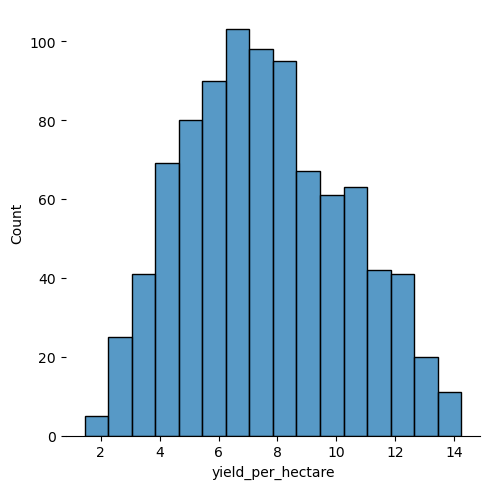

In [13]:
sns.displot(df['yield_per_hectare'])
sns.despine(left=True)

* **Our target variable seems to be normally distributed.** 
* **A normally distributed target variable is a good indication that the data is well-behaved and amenable to many common statistical methods and machine learning algorithms.**

> ### A. Regional Analysis

In [14]:
#Check number of regions
df.region.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [15]:
#Convert data type for 'region' field
df['region'] = df.region.astype('category')

<AxesSubplot: xlabel='region', ylabel='yield'>

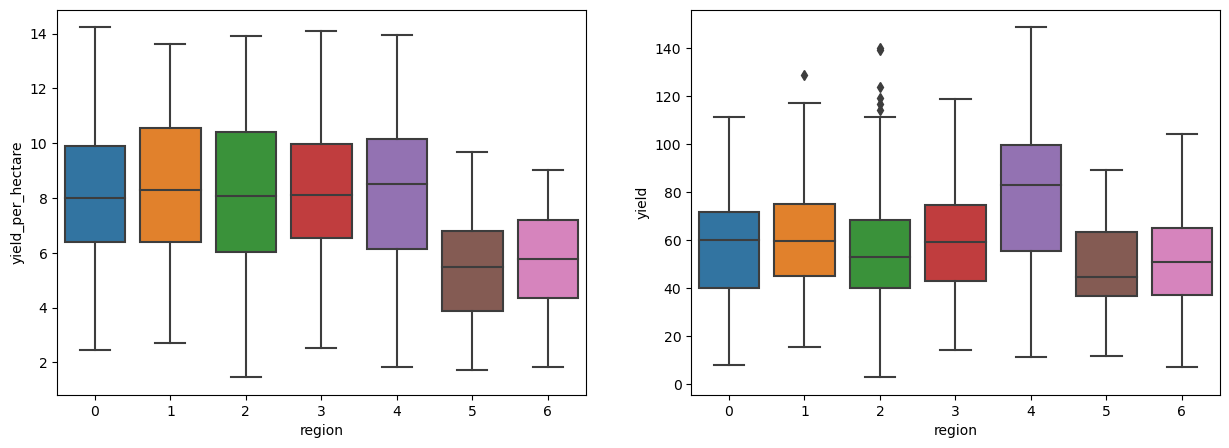

In [17]:
#Regional analysis
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))
sns.boxplot(data=df, x='region', y='yield_per_hectare', ax=ax0)
sns.boxplot(data=df, x='region', y='yield', ax=ax1)

* **If we assume no other factors affecting yield, Region 5 and 6 can be relatively *less fertile* than other regions based on first box-plot above.** 
* **We see similar trend when compared just the yield with different regions. Region 4 is clearly *largest producer* though!**

> ### B. Effect of Pesticide on Yield

In [18]:
#Assess the 'categories' field
df.categories.unique()

array(['b,a,c', 'c,a,d', 'd,a', 'd', 'b', 'b,c,a,d', 'c,b', 'd,b,c',
       'b,c', 'c,b,d', 'c,a', 'd,a,b', 'b,c,a', 'b,a', 'b,c,d,a', 'c',
       'b,d,c', 'c,a,d,b', 'c,b,d,a', 'a,c,b,d', 'a', 'b,d,c,a',
       'a,c,d,b', 'b,a,d', 'c,b,a', 'd,b', 'b,c,d', 'c,a,b', 'b,d',
       'd,a,c,b', 'a,c', 'b,a,d,c', 'd,c,a', 'c,d,a', 'a,b', 'd,c',
       'd,c,b', 'd,b,a,c', 'a,c,d', 'a,d,b', 'd,a,c', 'a,b,c', 'b,d,a',
       'd,b,c,a', 'c,d', 'd,c,b,a', 'a,c,b', 'd,a,b,c', 'b,a,c,d',
       'a,b,c,d', 'd,b,a', 'c,d,b', 'a,d', 'c,b,a,d', 'b,d,a,c',
       'c,a,b,d', 'a,d,c,b', 'c,d,a,b', 'a,d,b,c', 'c,d,b,a', 'a,b,d',
       'd,c,a,b'], dtype=object)

In [19]:
df['categories'] = df['categories'].str.replace(",","")
df.head(2)

,water,uv,area,fertilizer_usage,yield,pesticides,region,categories,yield_per_hectare
id,,,,,,,,,
169,5.615,65.281,3.230,0,7.977,8.969,0,bac,2.4697
476,7.044,73.319,9.081,0,23.009,7.197,0,cad,2.5338


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='char')
test = vectorizer.fit_transform(df['categories'])
print(vectorizer.get_feature_names_out())

print(test.toarray())

['a' 'b' 'c' 'd']
[[1 1 1 0]
 [1 0 1 1]
 [1 0 0 1]
 ...
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]]


In [21]:
cat_list = ['pesticide_a', 'pesticide_b', 'pesticide_c', 'pesticide_d']

df[cat_list] = test.toarray()

df = df.drop('categories', axis=1)

df.head(3)

,water,uv,area,fertilizer_usage,yield,pesticides,region,yield_per_hectare,pesticide_a,pesticide_b,pesticide_c,pesticide_d
id,,,,,,,,,,,,
169,5.615,65.281,3.230,0,7.977,8.969,0,2.4697,1,1,1,0
476,7.044,73.319,9.081,0,23.009,7.197,0,2.5338,1,0,1,1
152,5.607,60.038,2.864,2,23.019,7.424,0,8.0374,1,0,0,1


In [22]:
df['no_of_pesticides'] = df['pesticide_a']+df['pesticide_b']+df['pesticide_c']+df['pesticide_d']
df.head(2)

,water,uv,area,fertilizer_usage,yield,pesticides,region,yield_per_hectare,pesticide_a,pesticide_b,pesticide_c,pesticide_d,no_of_pesticides
id,,,,,,,,,,,,,
169,5.615,65.281,3.230,0,7.977,8.969,0,2.4697,1,1,1,0,3
476,7.044,73.319,9.081,0,23.009,7.197,0,2.5338,1,0,1,1,3


<AxesSubplot: xlabel='pesticides', ylabel='yield_per_hectare'>

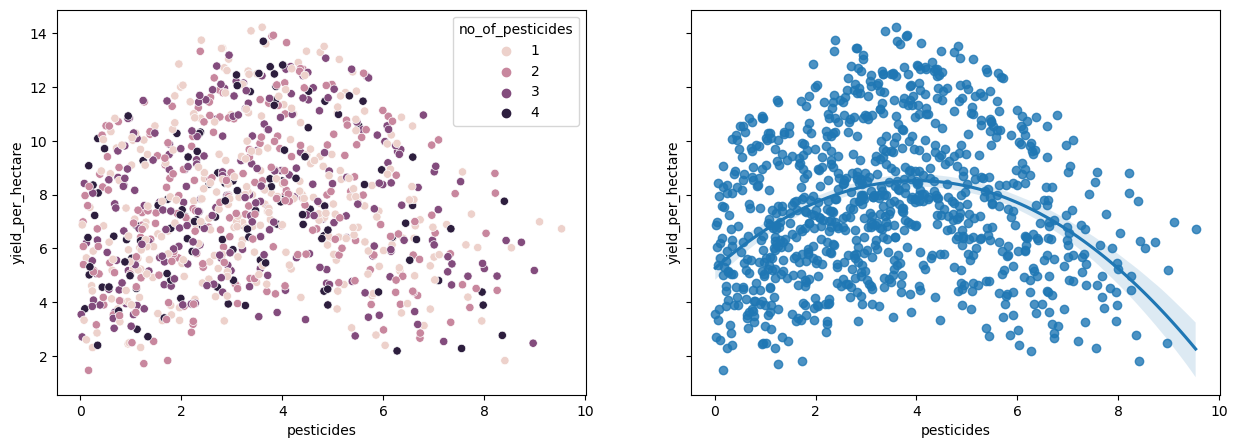

In [23]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))

sns.scatterplot(x='pesticides', y='yield_per_hectare', data=df, hue='no_of_pesticides', ax=ax0)
sns.regplot(x='pesticides', y='yield_per_hectare', data=df, order=2, ax=ax1)

* **From a high level look, number of different pesticides used have no clear effect on the yield produced per hectare. However, amount of pesticide used does show rise in yield up to certain amount and then it starts to decline with further increase in pesticide usage.**
* **The *optimum pesticide amount* that leads to maximum yield output is 3 to 5 units.**

In [24]:
df.groupby(['pesticide_a', 'pesticide_b', 'pesticide_c', 'pesticide_d'])['yield_per_hectare'].median().sort_values(ascending=False)

pesticide_a  pesticide_b  pesticide_c  pesticide_d
1            0            0            1              9.25835
0            0            0            1              9.12630
1            0            0            0              8.62980
0            0            1            1              8.27850
1            0            1            1              8.21475
             1            1            0              7.69410
                          0            0              7.59100
                                       1              7.37900
0            1            1            1              7.30610
1            0            1            0              7.30220
             1            1            1              7.17740
0            1            1            0              7.01265
                          0            0              6.85930
             0            1            0              6.44860
             1            0            1              6.38710
Name: yield_per_hec

* **If we look closely, from the table above we can say pesticide a, d and their other combinations does have higher median yield per hectare.**

Since, number of different pesticides used doesn't affect the yield, we can drop that column.

In [25]:
df = df.drop('no_of_pesticides', axis=1)

> ### C. Water usage

[]

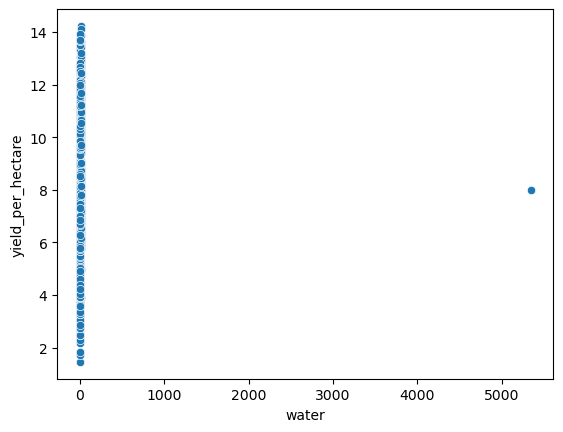

In [26]:
#water vs yield
_ = sns.scatterplot(x='water', y='yield_per_hectare', data=df)
plt.plot()

Here, one extreme value is suppressing the rest of the data points, making it difficult to visualize the relationship between the variables.

> **Handle Outliers**

In [27]:
df[df['water']>5000]

,water,uv,area,fertilizer_usage,yield,pesticides,region,yield_per_hectare,pesticide_a,pesticide_b,pesticide_c,pesticide_d
id,,,,,,,,,,,,
586,5340.0,91.224,8.429,2,67.321,2.933,0,7.9868,1,0,1,0


In [28]:
#drop the outlier
df.drop([586], axis=0, inplace=True)

[]

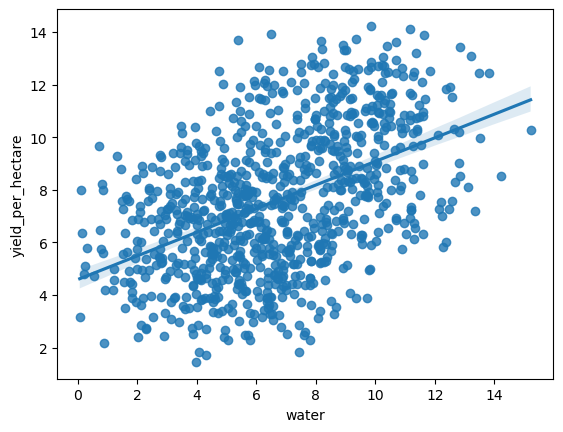

In [29]:
#water vs yield
_ = sns.regplot(x='water', y='yield_per_hectare', data=df)
plt.plot()

* **As expected, better irrigation leads to higher yield per hectare.**

> ### D. Exposure to Sunlight

<AxesSubplot: xlabel='uv', ylabel='region'>

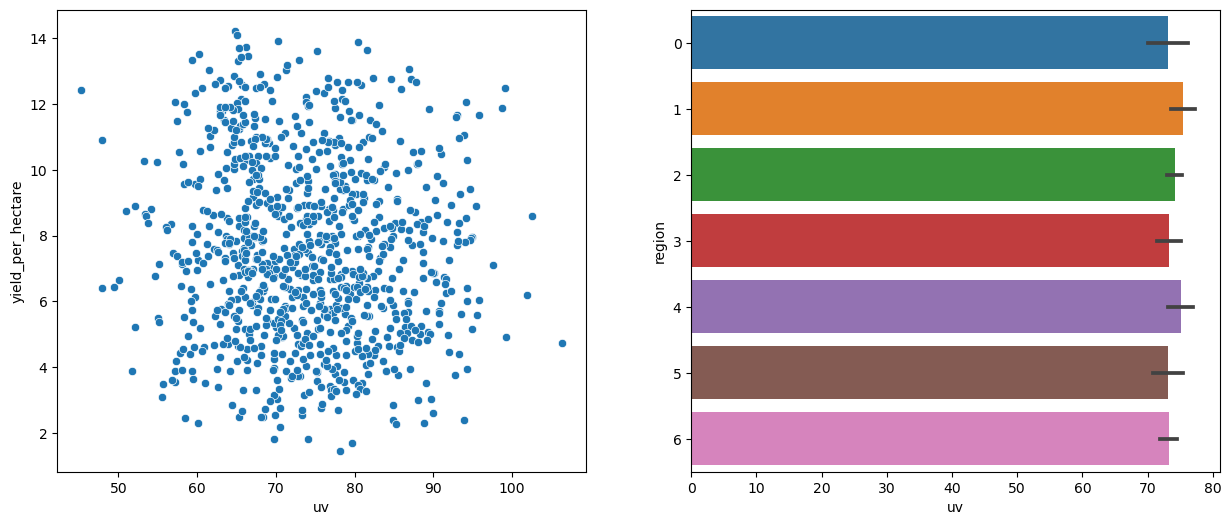

In [31]:
#UV vs yield
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,6))
sns.scatterplot(data=df, x='uv', y='yield_per_hectare', ax=ax0)
sns.barplot(data=df, x='uv', y='region', ax=ax1)
#plt.plot()

* **No clear relationship can be drawn between uv exposure and yield per hectare.**
* **All regions are exposed to almost same amout of sunlight. They must be located in one geographical region.**

> ### E. Fertilizer Usage

In [32]:
#We can drop 'yield' and 'area' fields as the information is included in 'yield-per_hectare'.
df = df.drop(['yield','area'], axis=1)

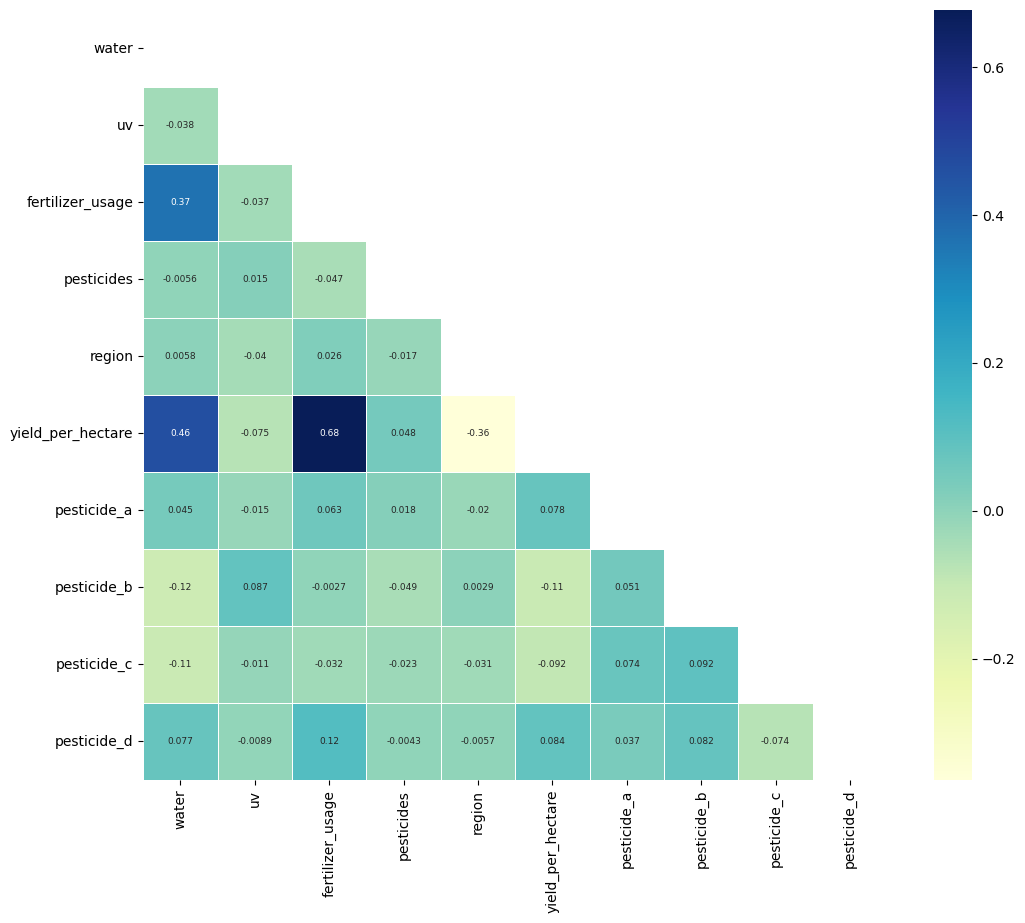

In [34]:
#Visualize the correlation between the fields using a heatmap
plt.figure(figsize=(12,10))
corr = df.corr(numeric_only=False)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap="YlGnBu",linewidths=0.5,annot=True,annot_kws={"size":6.5},mask=mask)
plt.show()

* **Clearly, level of fertilization is highly correlated to yield per hectare.**

<AxesSubplot: xlabel='fertilizer_usage', ylabel='yield_per_hectare'>

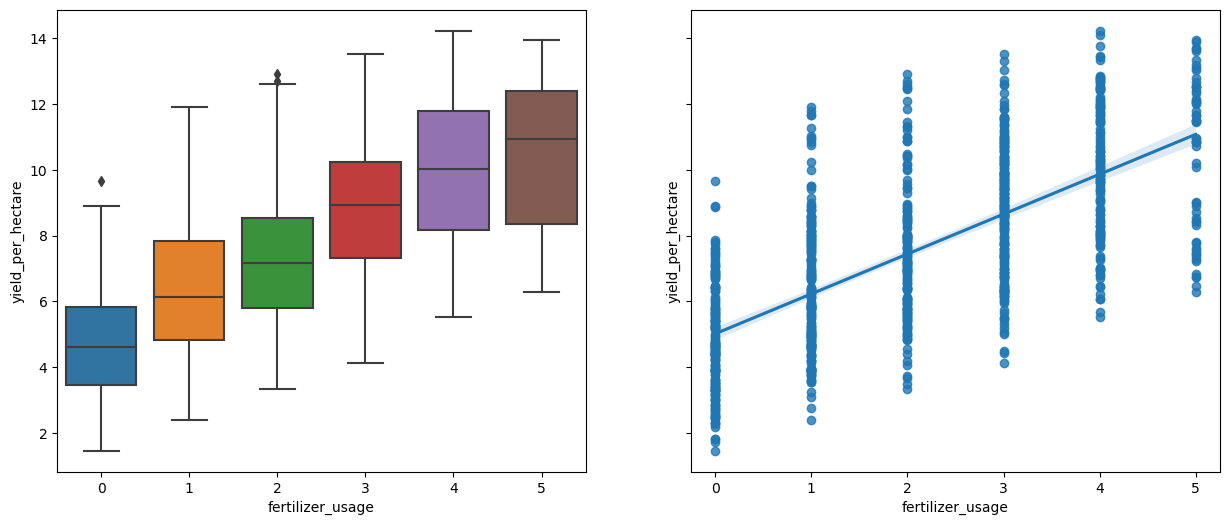

In [35]:
#Let's visualize the highly correlated variable with target vaiable
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,6))

sns.boxplot(data=df, x='fertilizer_usage', y='yield_per_hectare', ax=ax0)
sns.regplot(data=df, x='fertilizer_usage', y='yield_per_hectare', ax=ax1)

* **Higher the level of fertilization, more the yield per hectare.**
* **Although, higher fertilization leads to better produce, it is important to apply fertilizers in a judicious and targeted manner based on the specific needs of the crop and the soil, to minimize the environmental impacts of fertilization. This can involve using precision agriculture techniques to apply fertilizers only where and when they are needed, as well as using organic fertilizers and other sustainable farming practices.**

## 3. Training a Linear Regression Model

In the correlation heatmap above, we saw that water amount and fertilization level are positively correlated. Considering the uv amount being fairly close for most data points, we can fit a linear regression model to the dataset.

In [36]:
#Import tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, Ridge, Lasso
import joblib

In [37]:
#Define X and y
y = df['yield_per_hectare'].values
X = df.drop('yield_per_hectare', axis=1)

> ### A. One-Hot Encoding

In [38]:
#Get dummies for categorical features
X = pd.get_dummies(data=X, drop_first=True)

X.head()

,water,uv,fertilizer_usage,pesticides,pesticide_a,pesticide_b,pesticide_c,pesticide_d,region_1,region_2,region_3,region_4,region_5,region_6
id,,,,,,,,,,,,,,
169,5.615,65.281,0,8.969,1,1,1,0,0,0,0,0,0,0
476,7.044,73.319,0,7.197,1,0,1,1,0,0,0,0,0,0
152,5.607,60.038,2,7.424,1,0,0,1,0,0,0,0,0,0
293,9.346,64.719,2,1.256,0,0,0,1,0,0,0,0,0,0
564,5.920,78.735,2,1.136,0,1,0,0,0,0,0,0,0,0


> ### B. Handle Non-linearity

* We noticed in EDA stage that pesticide amount has a non-linear relationship with the target variable. In order to better fit a linear regression model, we need to introduce a higher order feature. Assuming a quadratic relationship between the two, we will add another column as a square of the pesticide amount.

In [39]:
X['pesticides_2'] = X['pesticides']**2
X.head(2)

,water,uv,fertilizer_usage,pesticides,pesticide_a,pesticide_b,pesticide_c,pesticide_d,region_1,region_2,region_3,region_4,region_5,region_6,pesticides_2
id,,,,,,,,,,,,,,,
169,5.615,65.281,0,8.969,1,1,1,0,0,0,0,0,0,0,80.442961
476,7.044,73.319,0,7.197,1,0,1,1,0,0,0,0,0,0,51.796809


> ### C. Create a pipeline, train a model, tune parameters

The correlation heatmap above deduce that the data has multicollinearity. We have multiple independent variables correlated with the target variable. Using simple linear regression model can lead to overfitting. Hence, we will train a Ridge regression model instead. Ridge regression can help to reduce the impact of multicollinearity and improve the stability of the coefficients.

Ridge regression is a type of linear regression that includes a regularization term in the model. The purpose of the regularization term is to add a penalty to the model for large coefficients, which can help to prevent overfitting and improve the stability of the model.

The mathematical formula for ridge regression can be expressed as:

minimize $|| y - X * beta ||^2 + lambda * || beta ||^2$

where y is the target variable, X is the matrix of independent variables, beta is the vector of coefficients to be estimated, and lambda is the regularization parameter.

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#Setup the pipeline steps for Ridge regression
steps = [('scaler', StandardScaler()),
        ('ridge', Ridge())]

#Create the pipeline
pipeline = Pipeline(steps)

#Specify the hyperparameter space
parameters = {'ridge__alpha':[1e-3,1e-2,1,2,3,4,4.25,4.5,4.75,5,5.25,5.5,10,15,20,25,30,35,40,45,50,55,100]}

#Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

#Create cv object
df_cv = GridSearchCV(pipeline, parameters) #scoring='neg_mean_squared_error' for MSE

#Fit to the training set
df_cv.fit(X_train, y_train)

#save the model to disk
model = 'best_model.sav'
joblib.dump(df_cv, model)

y_pred = df_cv.predict(X_test)

#Compute and print the metrics
r2 = df_cv.score(X_test, y_test)
#mse = mean_squared_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)
#mape = mean_absolute_percentage_error(y_test, y_pred)

print("Tuned Alpha: {}".format(df_cv.best_params_))
print("R squared: %.3f"%r2)

Tuned Alpha: {'ridge__alpha': 0.01}
R squared: 0.864


**Around 86% of the variance in the dependent variables is explained by the model. This is great!**

> ### D. Model Evaluation

Let's checkout other error metrics to better understand the model performance.

In [41]:
#Calculate variance of the residuals
mse = mean_squared_error(y_test, y_pred)
# Calulate standard deviation of residuls
rmse = mean_squared_error(y_test, y_pred, squared=False)
# Calculate average of residuals, i.e. Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
# Calculate the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error: %.3f"%mse)
print("Root Mean Squared Error: %.3f"%rmse)
print("Mean Absolute Error: %.3f"%mae)
print("Mean Absolute Percentage Error: %.3f"%mape)

Mean Squared Error: 1.116
Root Mean Squared Error: 1.057
Mean Absolute Error: 0.837
Mean Absolute Percentage Error: 0.129


MAPE of around 13% is acceptable accuracy for a baseline model. However, ideally, we would want less than 5% MAPE.

**Now, to check for overall heteroscedasticity, we will plot residuals and see if we find any patterns.**

Text(0, 0.5, 'residuals')

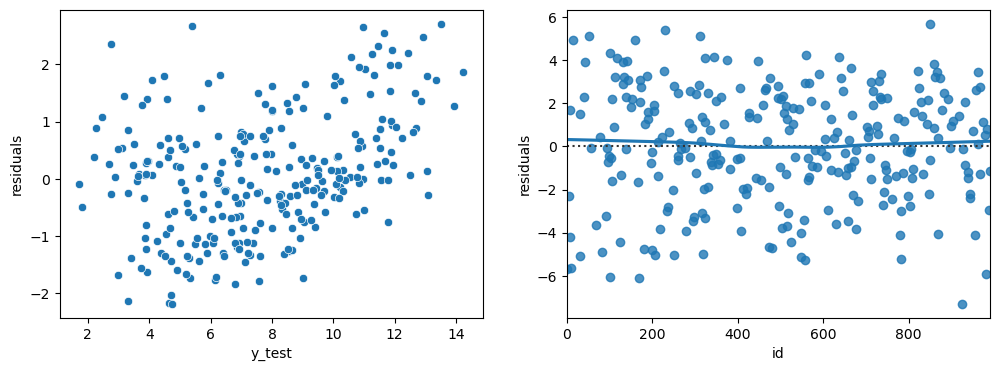

In [43]:
residuals = y_test - y_pred
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))
sns.scatterplot(x=y_test, y=residuals, ax=ax0)
sns.residplot(x=X_test.index, y=y_pred, lowess=True, ax=ax1)
ax0.set_xlabel('y_test')
ax0.set_ylabel('residuals')
ax1.set_ylabel('residuals')

From the first plot, we see that there is still some non-linearity in the dataset which has not been explained by the current model. The second plot shows that residuals are symmetrically distributed around zero line, which is a good for heteroscedasticity. However, residuals are varying by factor of 6 shows there is still room for improvement.

> ### E. Featue Importances

<AxesSubplot: >

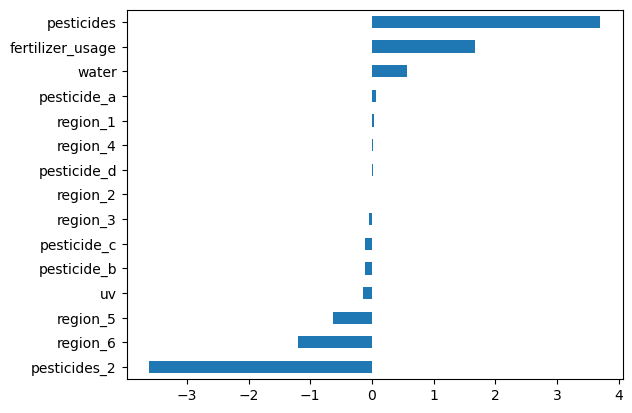

In [44]:
#Plot feature importances
imp_f = pd.Series(df_cv.best_estimator_._final_estimator.coef_, index=X.columns)
imp_f = imp_f.sort_values()
imp_f.plot(kind='barh')

* **The plot explains how amount of pesticides and fertilization level are bigest influensors in yield prediction. Being in region 5 or 6 also impacts the target varible estimation significantly.** 
* **As it should, based on our exploratory data analysis, model rewards higher fertilization level and pesticide amount to achieve better yield per hectare while penalizes too much of pesticide supply and farms being in region 5 or 6.**

## 4. Yield Prediction Tool

Now, since we have a model that can predict the yield for a given farm, a functional application can be built that can take farming conditions as an input and provide an estimate of yield per hectare as an output. Here, we will define a python function that can do the same. 

In [45]:
#Prediction tool

def yield_predictor(region_code=None, f_level=0, water=0, p_amount=0, p_types=None, uv=None):
    """
    This function takes input parameters related to a farm and returns a predicted yield per hectare.
    
    """
    region_code= int(input('Enter the Region code from the list (1,2,3,4,5,6):'))
    region_list = [0,0,0,0,0,0]
    region_list[int(region_code)-1] = 1
    #print('region list = {}'.format(region_list))
    f_level= float(input('Enter the level of fertilization from the list (0,1,2,3,4,5):'))
    water= float(input('Enter the amount of water to be supplied per hectare:'))
    p_amount= float(input('Enter the amount of pesticides used per hectare:'))
    uv= X_train.uv.median()
    
    p_types = []
    a = str.upper(input('Was Type A pesticide used? Enter Y/N:'))
    b = str.upper(input('Was Type B pesticide used? Enter Y/N:'))
    c = str.upper(input('Was Type C pesticide used? Enter Y/N:'))
    d = str.upper(input('Was Type D pesticide used? Enter Y/N:'))
    
    p_types_list = [a, b, c, d]
    p_types = [int(item.replace('Y', '1').replace('N', '0')) for item in p_types_list]
    #print('p_types= {}'.format(p_types))
    inputs = np.array([water,uv,f_level,p_amount,p_types[0],p_types[1],p_types[2],p_types[3],region_list[0],region_list[1],region_list[2],region_list[3],region_list[4],region_list[5],p_amount**2]).reshape(1,-1)
    X_test_userinput = pd.DataFrame(inputs, columns=X_test.columns)
    #print(X_test_userinput.head())
    pred = df_cv.predict(X_test_userinput)
    return print('The estimated yield per hectare for the given case is %.3f'%pred[0])
    

In [46]:
yield_predictor()

Enter the Region code from the list (1,2,3,4,5,6): 3
Enter the level of fertilization from the list (0,1,2,3,4,5): 1
Enter the amount of water to be supplied per hectare: 6.2
Enter the amount of pesticides used per hectare: 5.6
Was Type A pesticide used? Enter Y/N: Y
Was Type B pesticide used? Enter Y/N: N
Was Type C pesticide used? Enter Y/N: N
Was Type D pesticide used? Enter Y/N: Y


The estimated yield per hectare for the given case is 7.706


## 5. Conclusion

This analysis has provided valuable insights into the attributes and their effect of yield for 1000 farms. We identified key contributors in achieving higher yield and designed a tool that can estimate the yield for given farming practice.



> ### A. Recommendations

From the insights drawn from this project, following suggestions are provided, which can generate more profits and reduce principal costs.
> **1. Future investments decisions should be focussed on region 4, as it is the biggest revenue generator. Investigate region 5 and 6 for it's lower production rates.**

> **2. Ideal range for pesticide supply amount is 4 to 6 units per hectare. Type A pesticide is most promising for generating higher yield.**

> **3. Supply 8 or more units per hectare of water.**

> **4. Keep the fertilization level to 5.**


The use of machine learning algorithms enabled us to make predictions and recommendations that can inform our decision-making going forward, and help us optimize our use of resources, increase productivity, and maximize profitability.

> ### B. Future Scope

* **A resource allocation app can be deployed that gives estimate of raw materials (seeds, fertilizer, pesticides, water, electricity, etc.) for target yield for a given farm.**

* **Real-time weather, soil moisture, and crop health data can be collected to optimize planting, irrigation, and fertilization. By using AI and computer vision to analyze this data, more informed decisions can be made about farming operations, leading to increased crop yields and more sustainable farming practices.**

* **Aerial images of crops can be analysed to identify issues such as disease, pests, and nutrient deficiencies.**